In [324]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib as mtplt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from math import sqrt

In [325]:
# id:17--34--17 
df = pd.read_csv("./data/week3.csv")
df.columns = ['X1', 'X2', 'y']
df.head()

,X1,X2,y
0,0.41,-0.86,0.364486
1,0.97,-0.82,-0.856354
2,-0.25,-0.76,0.519532
3,-0.72,0.77,-1.755268
4,0.78,0.10,-1.437781


In [326]:
X1 = df['X1']
X2 = df['X2']
X = np.column_stack((X1, X2))
y = df['y']
point = np.column_stack((X1, X2, y))

### (i) 
(a) Plot the data you downloaded as a 3D scatter plot i.e. with the first feature on
the x-axis, the second feature in the y-axis and the target on the z-axis. You
can use the matplotlib scatter function for this, e..g for training data with two
features X and target y
Does it look like the training data lies on a plane or a curve ?


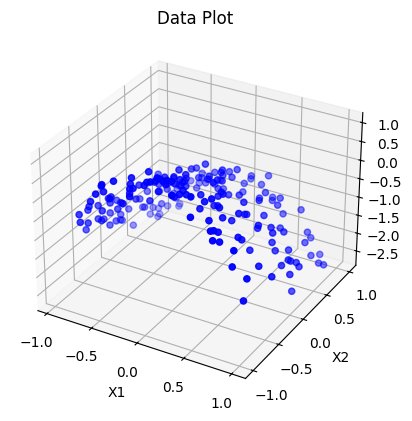

In [327]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X1, X2, y,color='blue', s=20, label='Original Data')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
ax.set_title('Data Plot')
plt.show()

In [328]:
marks = np.column_stack((X1, X2, y))
center = np.mean(marks, axis=0)
_, e_values, e_vectors = np.linalg.svd(marks - center, full_matrices=False)
normal = e_vectors[2]
dispersion = e_values[2]
print('normal: ', normal)
print('dispersion: ', dispersion)

normal:  [ 0.04174476 -0.8697575  -0.49171056]
dispersion:  5.143059947345105


(b) In addition to the two features in the data file add extra polynomial features
equal to all combinations of powers of the two features up to power 5 (you
can use the sklearn PolynomialFeatures function to do this). Now train Lasso
regression models with these polynomial features for a large range of values of
C e.g. 1, 10, 1000 (you might need to adjust these values for your data, start
by making C small enough that the trained model has all parameters zero, then
increase from there). Report the parameters of the trained models (don’t just
give a list of numbers, say what feature each parameter value corresponds to),
discuss how they change as C is varied.

In [329]:
def createTable(model_name):
    polynomial_values = [1, 2, 3, 4, 5]
    result_list = []

    for poly_degree in polynomial_values:
        poly_instance = PolynomialFeatures(degree=poly_degree)
        X_poly = poly_instance.fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.20, random_state=42)
        values_of_C = [5, 50, 100, 1000]
    
        for C in values_of_C:
            model_reg = any
            if model_name == "Lasso":
                model_reg = Lasso(alpha=1/(2*C))
            else:
                model_reg = Ridge(alpha=1/(2*C))
            
            model_reg.fit(X_train, y_train)
            coef = np.around(model_reg.coef_, decimals=3)
            intercept = np.around(model_reg.intercept_, decimals=3)
        
            result_list.append({
                'Polynomial Degree': poly_degree,
                'C': C,
                'Coefficients': coef,
                'Intercept': intercept
            })

    model_results = pd.DataFrame(result_list)

    pd.set_option('display.max_colwidth', 600)

    for poly_degree in polynomial_values:
        filtered_results = model_results[model_results['Polynomial Degree'] == poly_degree]
    
        styled_table = (
            filtered_results
            .style.set_table_styles(
                [
                    {'selector': 'thead th', 'props': [('background-color', 'white'), ('color', 'black'), ('font-size', '12pt')]},
                    {'selector': 'tbody td', 'props': [('background-color', 'white'), ('color', 'black'), ('border', '1px solid black')]},
                ]
            )
            .set_caption(f"Model results for Polynomial Degree {poly_degree}")
            .hide(axis='index')
        )
    
        display(styled_table)

createTable("Lasso")

Polynomial Degree,C,Coefficients,Intercept
1,5,[ 0. 0. -0.767],-0.707000
1,50,[ 0. 0.073 -1.023],-0.696000
1,100,[ 0. 0.088 -1.038],-0.695000
1,1000,[ 0. 0.101 -1.051],-0.694000


Polynomial Degree,C,Coefficients,Intercept
2,5,[ 0. 0. -0.76 -0.851 -0. 0. ],-0.414000
2,50,[ 0. 0. -1.008 -1.82 -0. 0. ],-0.075000
2,100,[ 0. 0. -1.022 -1.874 -0.009 0. ],-0.056000
2,1000,[ 0. 0.013 -1.037 -1.92 -0.052 0. ],-0.038000


Polynomial Degree,C,Coefficients,Intercept
3,5,[ 0. 0. -0.76 -0.851 -0. 0. 0. -0. 0. -0. ],-0.414000
3,50,[ 0. 0. -1.008 -1.82 -0. 0. 0. -0. 0. -0. ],-0.075000
3,100,[ 0. 0. -1.022 -1.874 -0.009 0. 0. -0. 0. -0. ],-0.056000
3,1000,[ 0. 0.02 -0.992 -1.919 -0.052 0.005 -0.026 -0.021 0.026 -0.063],-0.039000


Polynomial Degree,C,Coefficients,Intercept
4,5,[ 0. 0. -0.76 -0.851 -0. 0. 0. -0. 0. -0. -0. -0. -0. 0. -0. ],-0.414000
4,50,[ 0. 0. -1.008 -1.82 -0. 0. 0. -0. 0. -0. -0. -0. -0. -0. 0. ],-0.075000
4,100,[ 0. 0. -1.022 -1.874 -0.009 0. 0. -0. 0. -0. -0. -0. -0. -0. 0. ],-0.056000
4,1000,[ 0. 0.015 -0.994 -1.916 0. 0. -0.02 -0.018 0.035 -0.059 0. -0.1 -0.015 0. 0.008],-0.039000


Polynomial Degree,C,Coefficients,Intercept
5,5,[ 0. 0. -0.76 -0.851 -0. 0. 0. -0. 0. -0. -0. -0. -0. 0. -0. 0. -0. 0. -0. -0. -0. ],-0.414000
5,50,[ 0. 0. -1.008 -1.82 -0. 0. 0. -0. 0. -0. -0. -0. -0. -0. 0. 0. -0. 0. -0. 0. -0. ],-0.075000
5,100,[ 0. 0. -1.022 -1.874 -0.009 0. 0. -0. 0. -0. -0. -0. -0. -0. 0. 0. -0. 0. -0. 0. -0. ],-0.056000
5,1000,[ 0. 0.016 -0.988 -1.917 0. 0. -0. 0. 0.029 -0.063 0. -0.098 -0.006 0. 0.007 -0.026 -0.052 0. 0. -0. -0. ],-0.039000


In [330]:
min_X = min(min(X1),min(X2)) - 1
max_X = max((max(X1),max(X2))) + 1
print(min_X,max_X)

-2.0 2.0


In [331]:
def kFoldModel(model_name):
    
    grid_range = np.linspace(min_X, max_X, 50)

    X1Test, X2Test = np.meshgrid(grid_range, grid_range)
    Xtest = np.c_[X1Test.ravel(), X2Test.ravel()]

    polynomial_values = [1, 2, 3, 4, 5]
    values_of_C = [1, 5, 50, 100, 1000]

    for poly_degree in polynomial_values: 
        poly_instance = PolynomialFeatures(degree=poly_degree)
        X_poly = poly_instance.fit_transform(X)
        X_poly_test = poly_instance.fit_transform(Xtest)

        for C in values_of_C:
            model_reg = None
            if(model_name == "Ridge"):
                model_reg = Ridge(alpha=1/(2*C))
            else:
                model_reg = Lasso(alpha=1/(2*C)) 
                
            model_reg.fit(X_poly, y)
            predictions = model_reg.predict(X_poly_test)
            Z = predictions.reshape(X1Test.shape)
        
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            surface = ax.plot_surface(X1Test, X2Test, Z, color='lightgreen', alpha=0.6, rstride=1, cstride=1)
            scatter = ax.scatter(X1, X2, y, color='blue', s=20, label='Original Data')
            #surface_proxy = mlines.Line2D([0], [0], linestyle="none", color='lightgreen', marker='s', markersize=10)
            ax.legend([surface, scatter], [f'{model_name} Predictions', 'Original Data'], numpoints=1, loc='upper left')
            ax.set_xlabel('X1')
            ax.set_ylabel('X2')
            ax.set_zlabel('Y')
            ax.set_title(f'{model_name} Predictions (C={C}, Degree={poly_degree})')

            plt.show()


(c) For each of the models from (b) generate predictions for the target variable.
Generate these predictions on a grid of feature values. This grid should extend beyond the range of values in the dataset e.g. if the
first feature in the dataset has values from 0 to 2 generate predictions for values
from -5 to 5 or thereabouts. Plot these predictions on a 3D data plot and also
show the training data. Adjust the grid range used for the predictions so that the
training data can still be clearly seen in the plot. Its up to you to decide how best
to plot this data but do try to make your plot easy to read (suggestion: it can
be helpful to plot the predictions as a surface using the matplotlib plot surface
command and the training data as points using the matplotlib scatter command,
be sure to add a legend to identify the different curves). With reference to this
plot discuss how the predictions change as C is varied.

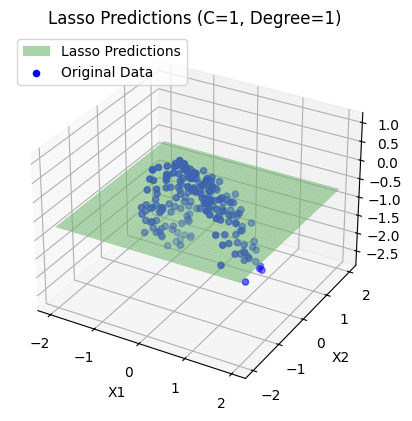

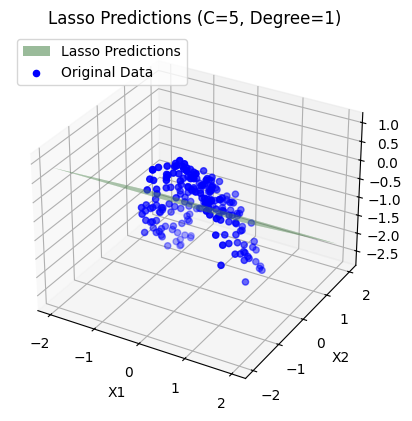

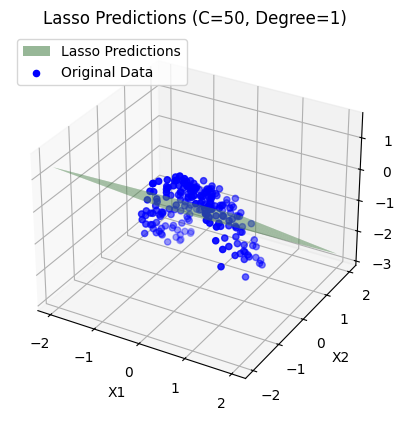

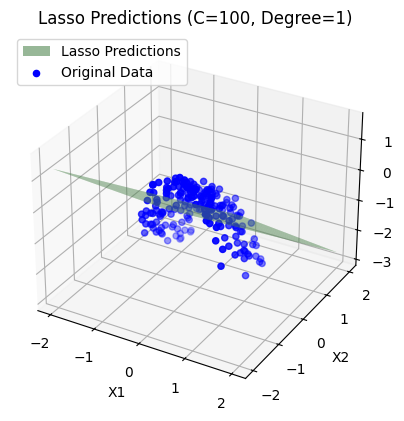

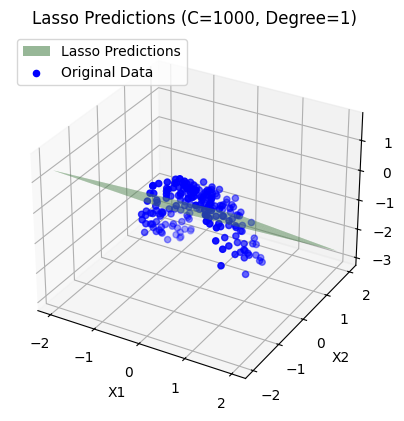

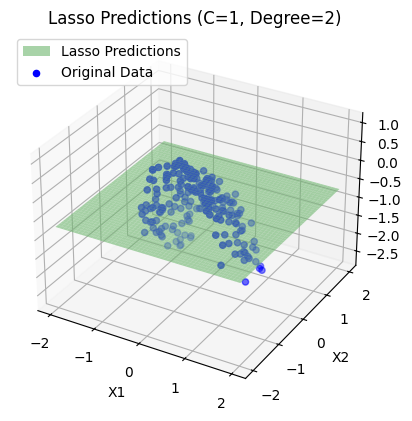

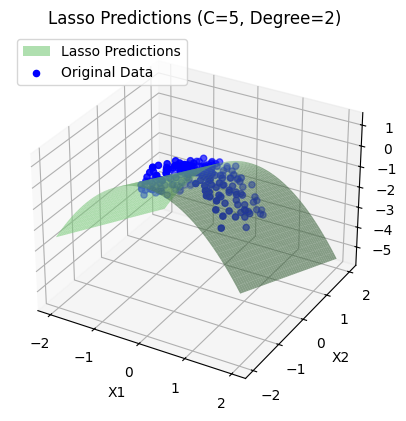

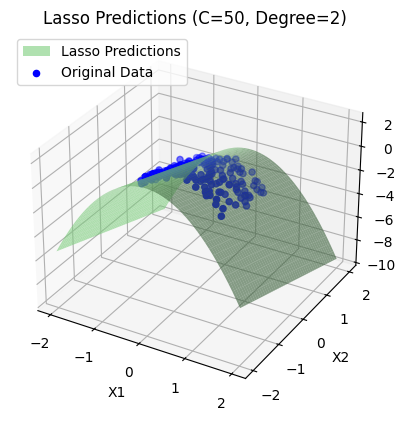

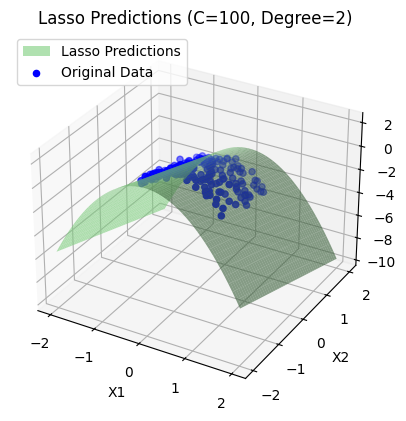

In [332]:
kFoldModel("Lasso")

(e) Repeat (b)-(c) for a Ridge Regression model. This uses an L2 penalty instead of
an L1 penalty in the cost function. Compare the impact on the model parameters
of changing C with Lasso Regression and with Ridge Regression

Polynomial Degree,C,Coefficients,Intercept
1,5,[ 0. 0.103 -1.05 ],-0.694000
1,50,[ 0. 0.103 -1.052],-0.693000
1,100,[ 0. 0.103 -1.052],-0.693000
1,1000,[ 0. 0.103 -1.052],-0.693000


Polynomial Degree,C,Coefficients,Intercept
2,5,[ 0. 0.014 -1.038 -1.911 -0.057 0.005],-0.043000
2,50,[ 0. 0.014 -1.039 -1.923 -0.057 0.005],-0.038000
2,100,[ 0. 0.014 -1.039 -1.924 -0.057 0.005],-0.038000
2,1000,[ 0. 0.014 -1.039 -1.924 -0.057 0.004],-0.038000


Polynomial Degree,C,Coefficients,Intercept
3,5,[ 0. 0.043 -0.964 -1.909 -0.055 0.014 -0.065 -0.043 0.033 -0.098],-0.045000
3,50,[ 0. 0.042 -0.977 -1.922 -0.056 0.013 -0.064 -0.035 0.035 -0.083],-0.040000
3,100,[ 0. 0.042 -0.978 -1.922 -0.056 0.013 -0.064 -0.034 0.035 -0.082],-0.040000
3,1000,[ 0. 0.042 -0.979 -1.923 -0.056 0.013 -0.064 -0.034 0.035 -0.082],-0.040000


Polynomial Degree,C,Coefficients,Intercept
4,5,[ 0. 0.036 -0.972 -1.783 0.038 0.03 -0.053 -0.025 0.048 -0.089 -0.109 -0.168 -0.119 -0.006 0.014],-0.060000
4,50,[ 0. 0.033 -0.981 -1.949 0.038 0.005 -0.055 -0.024 0.049 -0.08 0.052 -0.163 -0.067 -0.005 0.028],-0.038000
4,100,[ 0. 0.033 -0.981 -1.96 0.038 0.003 -0.055 -0.024 0.049 -0.08 0.063 -0.163 -0.063 -0.005 0.029],-0.036000
4,1000,[ 0.000e+00 3.300e-02 -9.820e-01 -1.971e+00 3.800e-02 1.000e-03 -5.500e-02 -2.500e-02 4.900e-02 -7.900e-02 7.300e-02 -1.620e-01 -6.000e-02 -5.000e-03 3.000e-02],-0.035000


Polynomial Degree,C,Coefficients,Intercept
5,5,[ 0. 0.039 -0.927 -1.783 0.026 0.056 -0.084 0.043 0.242 -0.262 -0.101 -0.174 -0.148 0.027 -0.008 0. -0.279 0.064 0.262 -0.3 0.1 ],-0.063000
5,50,[ 0. 0.017 -0.915 -1.953 0.011 0.049 -0.094 0.144 0.463 -0.363 0.068 -0.157 -0.097 0.055 -0.015 0.022 -0.445 -0.01 0.312 -0.524 0.182],-0.041000
5,100,[ 0. 0.014 -0.913 -1.965 0.009 0.049 -0.092 0.156 0.49 -0.374 0.081 -0.154 -0.093 0.058 -0.016 0.022 -0.461 -0.022 0.314 -0.549 0.192],-0.040000
5,1000,[ 0. 0.01 -0.912 -1.976 0.007 0.048 -0.089 0.167 0.517 -0.385 0.092 -0.151 -0.088 0.062 -0.017 0.022 -0.478 -0.034 0.316 -0.574 0.201],-0.039000


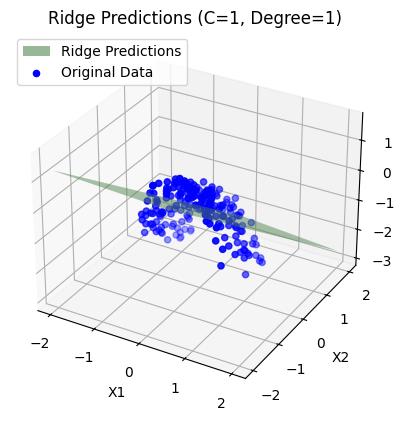

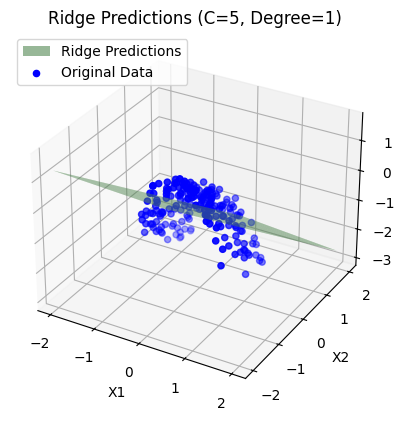

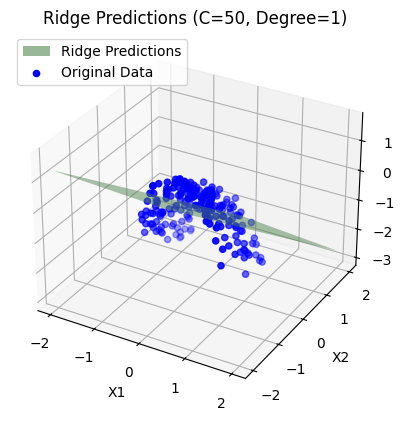

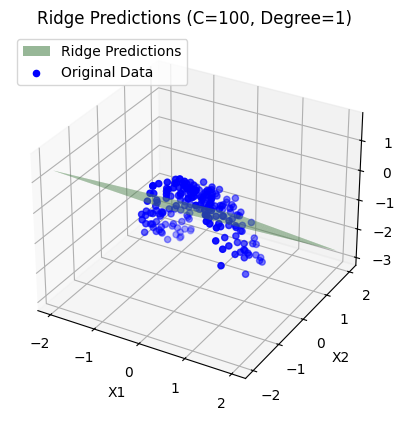

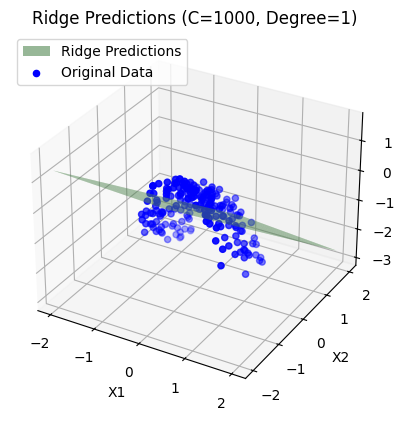

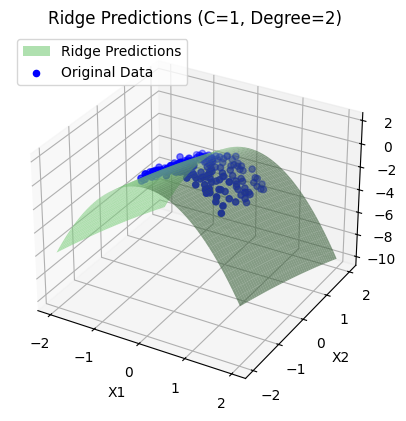

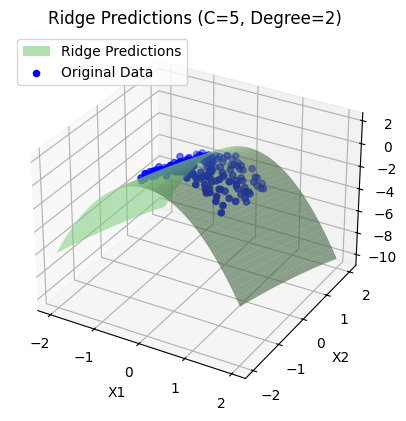

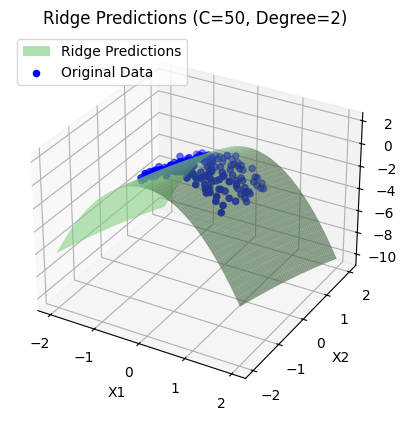

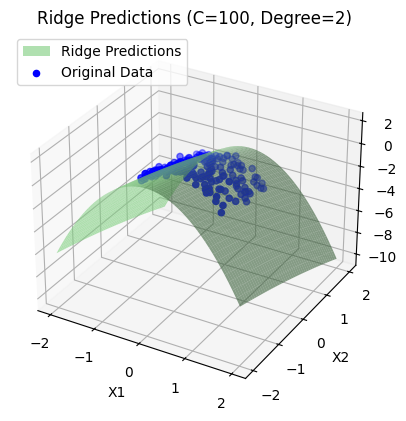

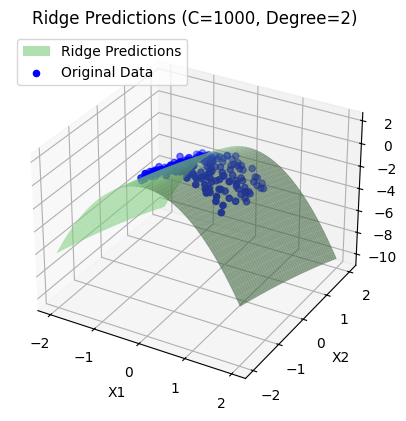

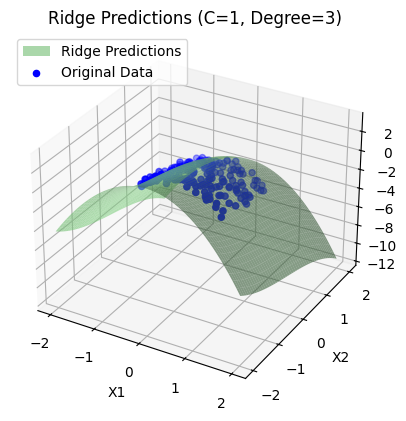

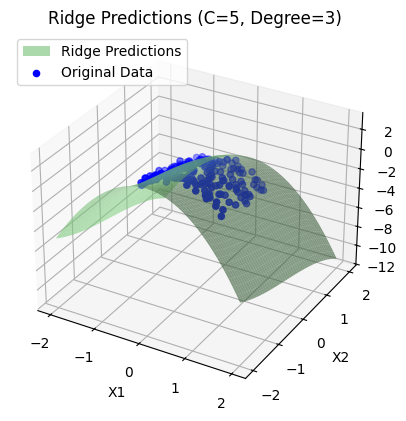

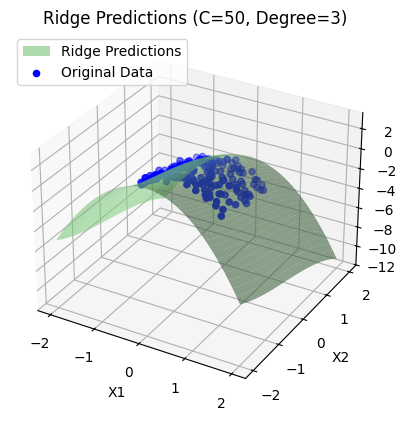

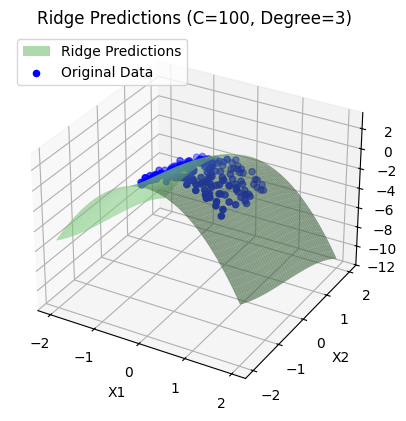

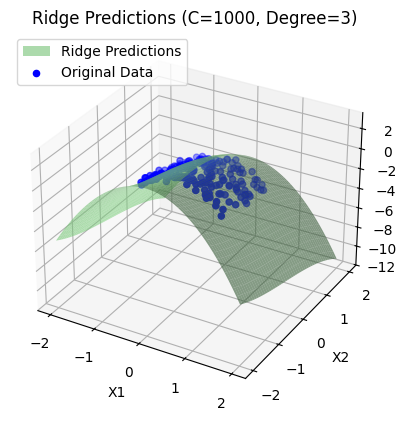

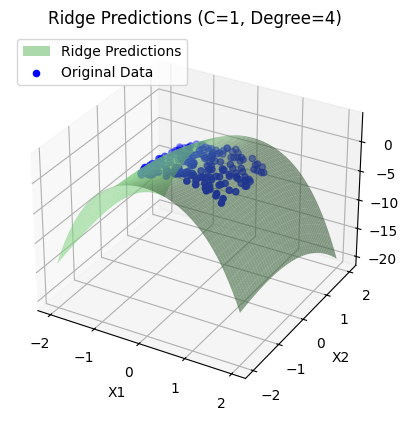

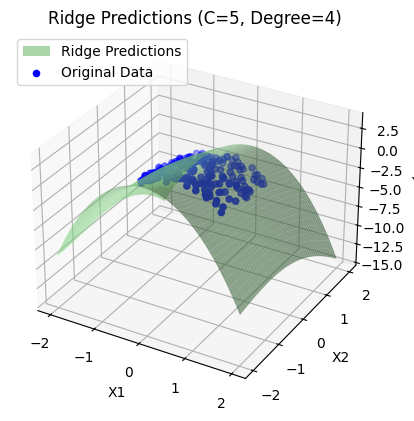

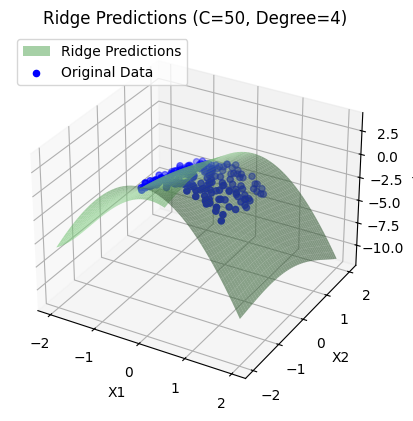

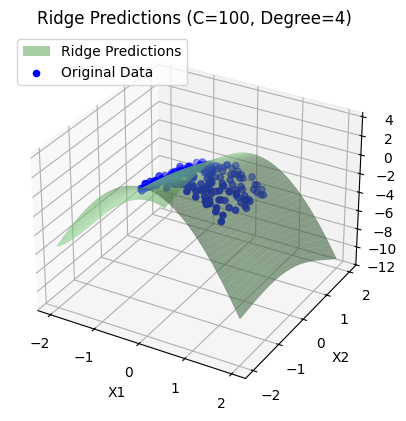

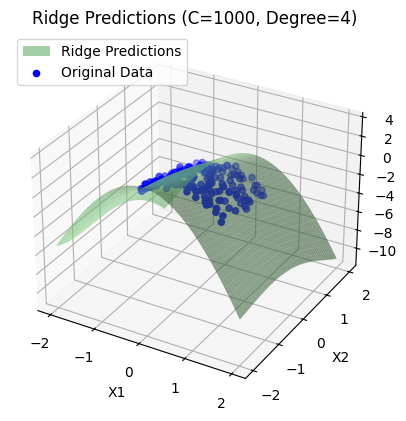

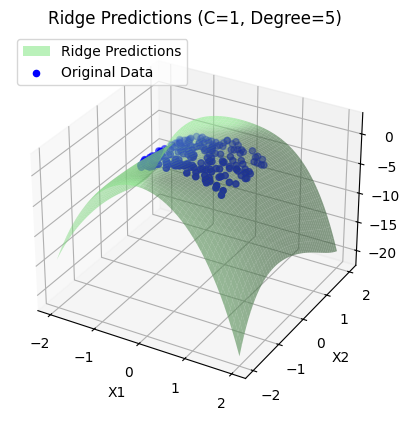

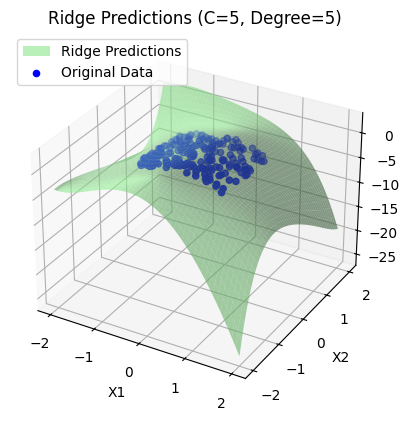

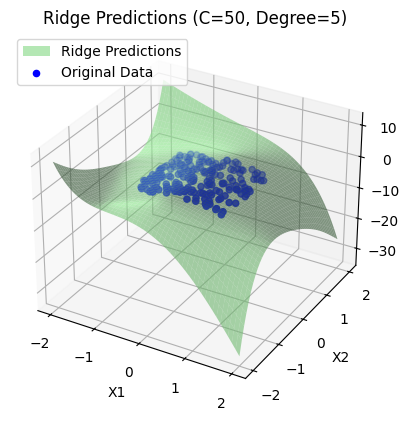

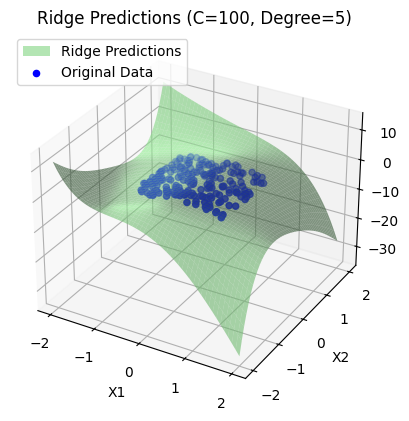

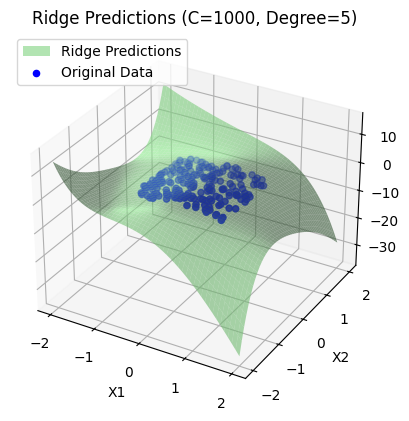

In [ ]:
createTable("Ridge")
kFoldModel("Ridge")

### (ii)

In [ ]:
def calulateErrorVsC(model_name):
    mean_error = []
    standard_deviation_error = []

    c_range = [1, 5, 10, 15, 25, 30, 40, 45, 100, 500, 1000]

    for C in c_range:
        model_reg = None
        if(model_name == "Lasso"):
            model_reg = Lasso(alpha=1/(2*C))
        else:
            model_reg = Ridge(alpha=1/(2*C))
            
        mean_square_error_array = []
        k_fold = KFold(n_splits=5)
        for train_index, test_index in k_fold.split(X):
            model_reg.fit(X[train_index], y[train_index])
            y_pred = model_reg.predict(X[test_index])
        
            # Calculate mean square error manually
            y_true = np.array(y[test_index])
            y_pred = np.array(y_pred)
            squared_diff = (y_true - y_pred) ** 2
            mean_square_error = np.mean(squared_diff)
            mean_square_error_array.append(mean_square_error)
    
        mean_error.append(np.mean(mean_square_error_array))
        standard_deviation_error.append(np.std(mean_square_error_array))

    plt.errorbar(c_range, mean_error, yerr=standard_deviation_error, fmt='-o')
    plt.xlabel('C')
    plt.ylabel(f'K-fold CV Mean Error for {model_name} Regression')
    plt.xlim((0, 55))
    plt.title(f'Error vs. C for {model_name} Regression')
    plt.show()


(a) Use 5-fold cross-validation to plot the mean and standard deviation of the pre-
diction error vs C. Use the matplotlib errorbar function for this. You will need
to choose the range of values of C to plot, justify your choice

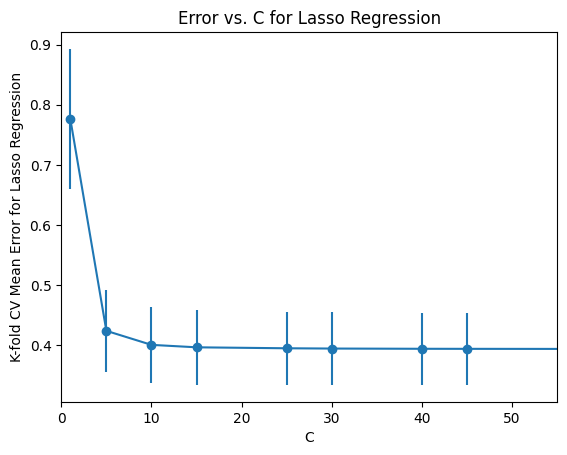

In [ ]:
calulateErrorVsC("Lasso")

(c) Repeat (b)-(c) for a Ridge Regression model

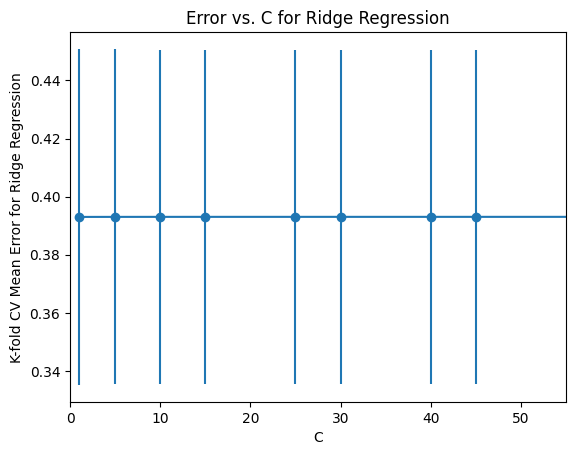

In [ ]:
calulateErrorVsC("Ridge")